In [63]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization, Input, Embedding, LSTM, Dense, Concatenate, Attention
from tensorflow.keras.models import Model
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import AdditiveAttention



In [64]:
# Check for GPU availbility
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Explicitly set GPU as preferred device (if available)
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF, as TensorFlow did not find a GPU.")

Num GPUs Available:  0
Please install GPU version of TF, as TensorFlow did not find a GPU.


In [65]:


# Data Reading
dataframe = pd.read_csv('pro_corpus.csv')
assert 'AAVE' in dataframe.columns and 'SAE' in dataframe.columns


In [66]:

# Preparing the dataset
aave_texts = dataframe['AAVE'].str.lower().tolist()
sae_texts = dataframe['SAE'].str.lower().tolist()

# Split the data into train and test sets
aave_train, aave_test, sae_train, sae_test = train_test_split(
    aave_texts, sae_texts, test_size=0.2, random_state=42)

# Convert the train and test data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices({
    'aave': aave_train,
    'sae': sae_train
})
test_dataset = tf.data.Dataset.from_tensor_slices({
    'aave': aave_test,
    'sae': sae_test
})


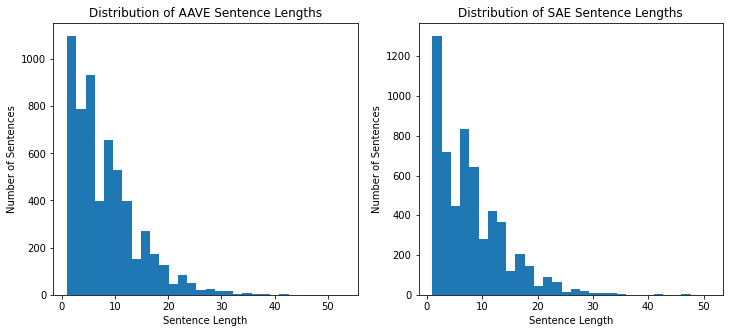

In [67]:
import matplotlib.pyplot as plt

# Assuming 'aave_texts' and 'sae_texts' are your datasets
aave_lengths = [len(sentence.split()) for sentence in aave_texts]
sae_lengths = [len(sentence.split()) for sentence in sae_texts]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(aave_lengths, bins=30)
plt.title('Distribution of AAVE Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')

plt.subplot(1, 2, 2)
plt.hist(sae_lengths, bins=30)
plt.title('Distribution of SAE Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')
plt.show()


In [68]:

BUFFER_SIZE = len(aave_train)  # Use the size of the train dataset

# Adjust batch sizes
train_batch_size = 16
test_batch_size = 4

# Shuffle and batch the train dataset
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(train_batch_size, drop_remainder=True)

# Batch the test dataset
test_dataset = test_dataset.batch(test_batch_size, drop_remainder=True)

In [69]:
# Text Vectorization
aave_vectorization = TextVectorization(output_mode='int', output_sequence_length=30)
sae_vectorization = TextVectorization(output_mode='int', output_sequence_length=30)

aave_texts = train_dataset.map(lambda x: x['aave'])
sae_texts = train_dataset.map(lambda x: x['sae'])

aave_vectorization.adapt(aave_texts)
sae_vectorization.adapt(sae_texts)

aave_vocab_size = len(aave_vectorization.get_vocabulary())
sae_vocab_size = len(sae_vectorization.get_vocabulary())

In [70]:
# Model Parameters
embedding_dim = 256
units = 1024
num_heads = 4  # Number of attention heads

In [71]:
# Building the Enhanced Model
# Encoder
encoder_input = Input(shape=(None,), dtype='int64', name='encoder_input')
encoder_embedding = Embedding(input_dim=aave_vocab_size, output_dim=embedding_dim)(encoder_input)
encoder_lstm = LSTM(units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_lstm2 = LSTM(units, return_sequences=True, return_state=True)
encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs)
encoder_state = [state_h2, state_c2]

# Decoder
decoder_input = Input(shape=(None,), dtype='int64', name='decoder_input')
decoder_embedding = Embedding(input_dim=sae_vocab_size, output_dim=embedding_dim)(decoder_input)
decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
decoder_lstm_output, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_state)
decoder_lstm2 = LSTM(units, return_sequences=True, return_state=True)
decoder_lstm_output2, _, _ = decoder_lstm2(decoder_lstm_output)

# Attention Mechanism
attention_layer = Attention(use_scale=True)
attention_output = attention_layer([decoder_lstm_output2, encoder_outputs2])

# Concatenation
decoder_concat_input = Concatenate(axis=-1)([decoder_lstm_output2, attention_output])

# Output Layer
decoder_dense = Dense(sae_vocab_size, activation='softmax')
decoder_output = decoder_dense(decoder_concat_input)

model = Model([encoder_input, decoder_input], decoder_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [72]:

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 embedding_19 (Embedding)       (None, None, 256)    738816      ['encoder_input[0][0]']          
                                                                                                  
 decoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 lstm_22 (LSTM)                 [(None, None, 1024)  5246976     ['embedding_19[0][0]']           
                                , (None, 1024),                                             

In [74]:


def split_input_target(batch):
    input_text = batch['aave']
    target_text = batch['sae']

    input_data = aave_vectorization(input_text)
    target_data = sae_vectorization(target_text)

    # Ensure all sequences in the batch have the same length
    sequence_length = 30
    input_data = tf.ensure_shape(input_data, [None, sequence_length])
    target_data = tf.ensure_shape(target_data, [None, sequence_length])

    return {'encoder_input': input_data, 'decoder_input': target_data[:, :-1]}, target_data[:, 1:]

# Apply the function to each item in the dataset
train_dataset = train_dataset.map(split_input_target).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(split_input_target).prefetch(tf.data.AUTOTUNE)


In [75]:
# Train the model
epochs = 10

# Callbacks for Early Stopping and Model Checkpoint
checkpoint_filepath = '/N/u/saswar/Carbonate/AAVE/'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=4,
    verbose=1)

# Train the model with validation split and callbacks
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[early_stopping_callback, model_checkpoint_callback])


Epoch 1/10


2023-12-29 15:43:33.379535: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "AuthenticAMD" model: "241" frequency: 2249 num_cores: 128 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 524288 l3_cache_size: 268435456 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


 11/289 [>.............................] - ETA: 2:41 - loss: 3.3043 - accuracy: 0.6955

KeyboardInterrupt: 

In [ ]:

# Plotting and saving the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('loss_curve_M2.png')
plt.show()


# Function to calculate BLEU score and save results to CSV
def calculate_and_save_bleu(model, dataset, filename='translation_results_M2.csv'):
    results = []
    bleu_scores = []
    smoothie = SmoothingFunction().method4 

    for batch in dataset:
        input_data, target_data = batch
        predictions = np.argmax(model.predict(input_data), axis=-1)

        for input_seq, pred, actual in zip(input_data['encoder_input'], predictions, target_data):
            input_sentence = [aave_vectorization.get_vocabulary()[i] for i in input_seq.numpy() if i != 0]
            pred_sentence = [sae_vectorization.get_vocabulary()[i] for i in pred if i != 0]
            actual_sentence = [sae_vectorization.get_vocabulary()[i] for i in actual.numpy() if i != 0]

            if len(pred_sentence) == 0 or len(actual_sentence) == 0:
                continue

            bleu_score = sentence_bleu([actual_sentence], pred_sentence, smoothing_function=smoothie)
            bleu_scores.append(bleu_score)

            results.append({
                'AAVE Sentence': ' '.join(input_sentence),
                'Predicted SAE Translation': ' '.join(pred_sentence),
                'Target SAE Translation': ' '.join(actual_sentence),
                'BLEU Score': bleu_score
            })

    pd.DataFrame(results).to_csv(filename, index=False)
    average_bleu_score = np.mean(bleu_scores) if len(bleu_scores) > 0 else 0.0
    return average_bleu_score

# Calculate BLEU score, save the results, and print the average BLEU score
average_bleu_score = calculate_and_save_bleu(model, test_dataset)
print(f"Overall BLEU Score: {average_bleu_score}")

# Load the best model
best_model = tf.keras.models.load_model(checkpoint_filepath)
best_model.save('best_model_M2.h5')  # Save the full model in HDF5 format

print("Best model saved as 'best_model_M2.h5'")